In [2]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

In [3]:
data_dir = "word2vec_data/words"
data_url = "http://mattmahoney.net/dc/text8.zip"

In [4]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
    
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [5]:
words = fetch_words_data()

In [6]:
len(words)

17005207

In [7]:
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [8]:
for w in words[9000:9040]:
    print(w,end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

In [9]:
from collections import Counter

In [10]:
my_list = ["one",'two','two']

In [13]:
Counter(my_list).most_common(2)

[('two', 2), ('one', 1)]

In [14]:
def create_counts(vocab_size=50000):
    
    vocab = [] + Counter(words).most_common(vocab_size)
    
    vocab = np.array([word for word, _ in vocab ])
    
    dictionary = {word:code for code, word in enumerate(vocab)}
    
    data = np.array([dictionary.get(word,0) for word in words])
    
    return data,vocab

In [15]:
data , vocabulary = create_counts()

In [16]:
data.shape

(17005207,)

In [17]:
vocabulary.shape

(50000,)

In [18]:
words[100]

'interpretations'

In [19]:
data[100]

4186

In [20]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [21]:
# CONSTANTS

In [22]:
batch_size = 128

embedding_size = 150

skip_window = 1

num_skips = 2

In [23]:
valid_size = 16

In [24]:
valid_window = 100
valid_examples = np.random.choice(valid_window,valid_size,replace=False)

In [25]:
num_sampled = 64

In [26]:
learning_rate = 0.01

In [27]:
vocabulary_size = 50000

In [28]:
tf.reset_default_graph()

In [29]:

train_inputs = tf.placeholder(tf.int32,shape=[None])

In [30]:
train_labels = tf.placeholder(tf.int32,shape=[batch_size,1])

In [31]:
valid_dataset = tf.constant(valid_examples,dtype=tf.int32)

In [32]:
init_embeds = tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0)

In [33]:
embeddings = tf.Variable(init_embeds)

In [34]:
embed = tf.nn.embedding_lookup(embeddings,train_inputs)

In [35]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0/np.sqrt(embedding_size)))

In [36]:
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [37]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights,nce_biases,train_labels,embed,num_sampled,vocabulary_size))

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [40]:
# Compute the cosine similarity between minibatch examples and all embeddings!
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [41]:
data_index = 0

In [42]:
init = tf.global_variables_initializer()

In [43]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [46]:
num_steps = 5000
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(init)
    average_loss = 0
    
    for step in range(num_steps):
        
        batch_inputs , batch_labels = generate_batch(batch_size,num_skips,skip_window)
        feed_dict = {train_inputs: batch_inputs,train_labels:batch_labels}
        
        _,loss_val = sess.run([trainer,loss],feed_dict=feed_dict)
        
        average_loss += loss_val
        
        if step % 1000 == 0:
            if step > 0:
                average_loss = average_loss/1000
            print("Average Loss at step ",step," is: ",average_loss)
            average_loss = 0
            
        final_embeddings = normalized_embeddings.eval()

Average Loss at step  0  is:  278.52835083
Average Loss at step  1000  is:  9224.0836544
Average Loss at step  2000  is:  20826.354437
Average Loss at step  3000  is:  26556.0717828
Average Loss at step  4000  is:  34371.6490102


In [47]:
final_embeddings.shape

(50000, 150)

In [49]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000)

In [74]:
plot_only = 500

In [75]:
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [76]:
labels = [vocabulary[i] for i in range(plot_only)]

In [77]:
low_dim_embed.shape

(500, 2)

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

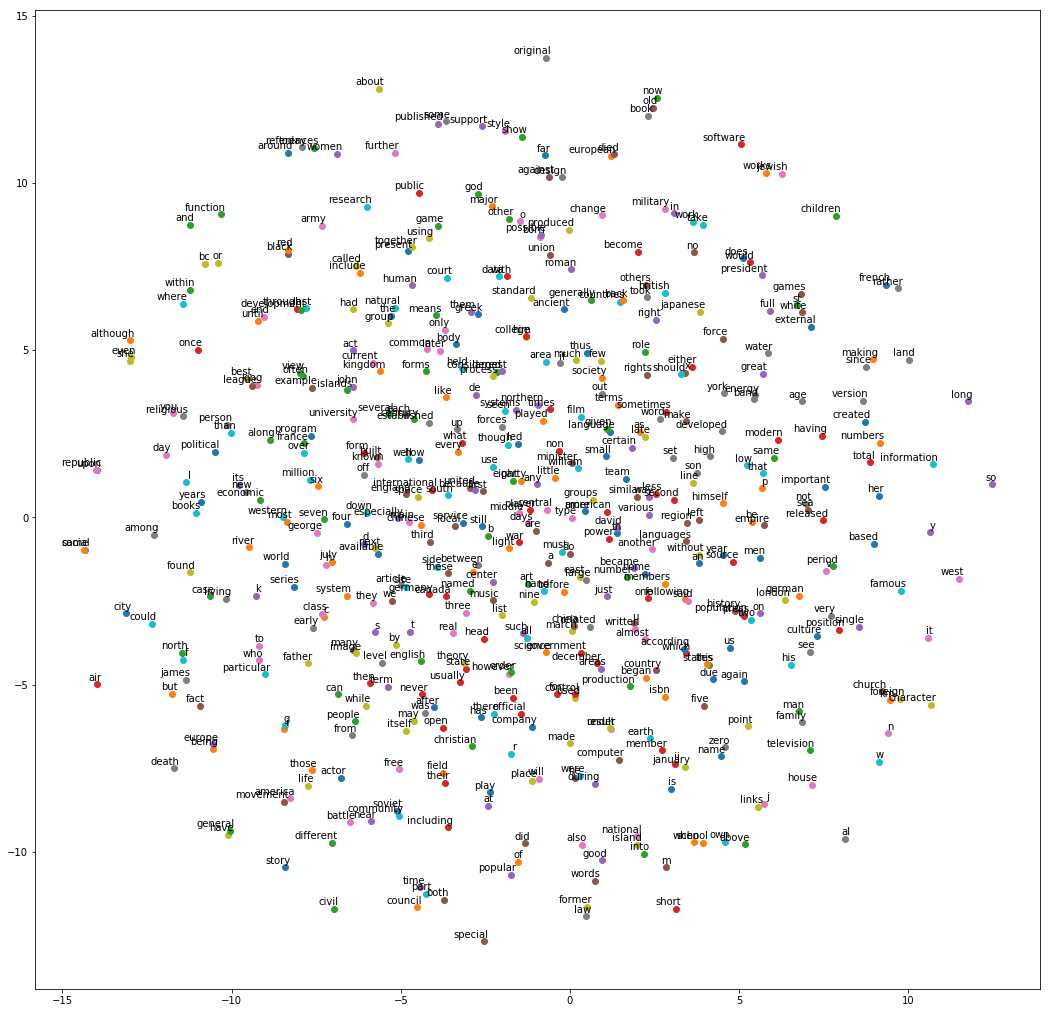

In [80]:
plot_with_labels(low_dim_embed, labels)

In [59]:
final_embeddings = np.load("trained_embeddings_200k_steps.npy")

In [60]:
final_embeddings.shape

(50000, 150)